In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')
import pickle

# Load data and model

In [2]:
# PNLs in the data is calculated by forward looking 120 day
test_len = 60

In [3]:
# This is the output of the data processing for both option1 and 2
processed_data = pd.read_csv('../Outputs/data_pipeline_output.csv')

In [4]:
# model that predicts entry apperance
with open('../Outputs/entry_model_latest.pkl', 'rb') as file:
    entry_model = pickle.load(file)

In [5]:
# model that predicts exit appearce
with open('../Outputs/exit_model_latest.pkl', 'rb') as file:
    exit_model = pickle.load(file)

# Define the testing period

In training the models above, we used data up to 2021-8-10.

In [6]:
future_data = processed_data[processed_data.Date>'2021-08-10']

training_data = processed_data[processed_data.Date<='2021-08-10']

# Get SPY returns

In [7]:
spy_df = pd.read_csv('../Data/Training/1999-12-01-2023-12-31_SPY.csv')
spy_df = spy_df[['Date','Adj Close']]
spy_df.columns = ['Date','SPY_Close']

look_forward_d = test_len
# Define a variable to calculate the return if we just buy SPY and sell in the next 60 days
spy_return = []
for i in range(spy_df.shape[0]):
    if (i + look_forward_d) < spy_df.shape[0]:
        spy_return.append(
            (spy_df.loc[i+look_forward_d]['SPY_Close'] - spy_df.loc[i]['SPY_Close'])/spy_df.loc[i]['SPY_Close']
        )
    else:
        spy_return.append(
            np.nan
        )
spy_df['SPY_return'] = spy_return

In [8]:

# Predict entry apperances in the next 1-3 days
pred_entry = entry_model.predict(future_data[entry_model.feature_names.values])

# Predict exit appearance in the next 9-12 days
pred_exit = exit_model.predict(future_data[entry_model.feature_names.values])

future_data['entry_appears'] = pred_entry
future_data['exit_appears'] = pred_exit

# get the next 60d PNL from S&P
future_data = pd.merge(
    future_data, 
    spy_df, 
    how='left',
    left_on='Date',
    right_on='Date'
)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=196, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=196
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


# Strategy

1. The original option 2 trade strategy when executing pair trading (need to understand which parameters were used when generating data './pair_features_1_pairs500_300_120.csv')

2. Only spend on pair trading if:
    1. Entry and exit are both predicted to be 1
    2. cosine_sim > 0.8
  
3. We invest part of the money on S&P500 and part of the money on pair-trading. During the next 60 days, if a qualified stock pair does not have entry signal then we do not invest that part of the money
    1. For each qualified stock pair, we invest the same amount of money

In [120]:
qualified_pairs = future_data[
    (future_data.entry_appears == 1) & 
    # (future_data.exit_appears == 1) & 
    (future_data.stock2vec_cos_sim>0.95)
]

In [121]:
pair_trading_return = qualified_pairs[['Date','pnls']].groupby('Date').agg(['mean','size']).reset_index()
pair_trading_return.columns = ['Date', 'pair_trade_pnls', 'num_pairs_identified']
pair_trading_return.num_pairs_identified = pair_trading_return.num_pairs_identified.fillna(0)

In [122]:
future_data_spy = future_data[['Date','SPY_return']].drop_duplicates()

In [123]:
final_return = pd.merge(future_data_spy,pair_trading_return,how='left',on='Date')

In [124]:
# when we did not detect any pairs, we invest everything in SPY
# final_return.pair_trade_pnls.fillna(final_return.SPY_return,inplace=True)
final_return.pair_trade_pnls.fillna(0,inplace=True)
final_return.num_pairs_identified.fillna(0, inplace=True)

In [125]:
final_return[final_return.SPY_return<0][['pair_trade_pnls','SPY_return']].describe()

,pair_trade_pnls,SPY_return
count,231.000,231.000
mean,0.011,-0.060
std,0.056,0.041
min,-0.264,-0.184
25%,0.000,-0.081
50%,0.000,-0.050
75%,0.032,-0.030
max,0.256,-0.001


In [126]:
final_return.num_pairs_identified.describe()

count   541.000
mean      1.327
std       1.273
min       0.000
25%       0.000
50%       1.000
75%       2.000
max       4.000
Name: num_pairs_identified, dtype: float64

count   541.000
mean      0.006
std       0.023
min      -0.076
25%       0.000
50%       0.000
75%       0.000
max       0.102
Name: delta, dtype: float64

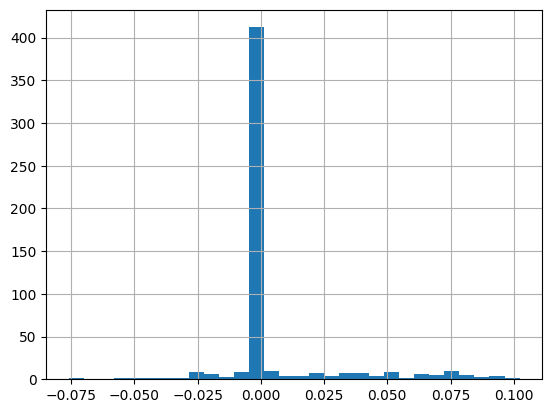

In [98]:
share_for_sp500 = 0.5
final_return['strategy_return'] = \
(share_for_sp500*final_return['SPY_return'] + (1-share_for_sp500)*final_return['pair_trade_pnls'])
final_return['delta'] = final_return.strategy_return - final_return['SPY_return']
final_return['delta'].hist(bins=30)
final_return['delta'].describe()

count   541.000
mean      0.012
std       0.058
min      -0.118
25%      -0.030
50%       0.016
75%       0.055
max       0.135
Name: strategy_return, dtype: float64

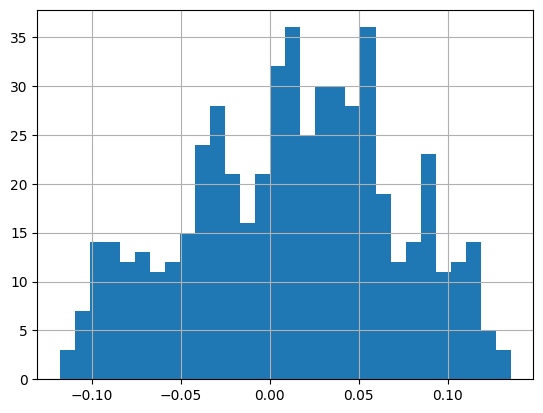

In [99]:
final_return['strategy_return'].hist(bins=30)
final_return['strategy_return'].describe()